In [38]:
import gensim
#model = gensim.models.KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin.gz", binary=True)
#model = gensim.models.Word2Vec.load("../models/custom_w2v")
w2v_model = gensim.models.Word2Vec.load("../models/custom_w2v_intersect_GoogleNews")
w2v_model.init_sims(replace=True) #precomputed l2 normed vectors in-place – saving the extra RAM

In [4]:
from GAIL import get_cosine_sim, get_action, get_raw_action
import torch

In [5]:
d = torch.load('../dat/processed/padded_vectorized_states_v3.pt')
#d = torch.load('../dat/processed/vectorized_states_v3.pt')
raw = torch.load('../dat/processed/raw_states_v3.pt')

In [6]:
for index, vects in d.items():
    # each is N x 300
    input_state, next_state = vects[0], vects[1]
    # raw strings corresponding to embeddings
    raw_input_state, raw_next_state = list(raw.keys())[index], raw[list(raw.keys())[index]]
    print(raw_input_state)
    print(input_state)
    print(raw_next_state)
    print(next_state)
    if index > 1:
        break

go find one .
tensor([ 51, 217, 105,   0,   0])
<person> 's name .
tensor([  5,   8, 170,   0,   0])


In [7]:
s1 = torch.rand(size = (5, 50))
s2 = torch.rand(size = (5, 50))
get_cosine_sim(s1, s2)

0.95867693

In [196]:
import torch.nn as nn
import torch.nn.functional as F

import gensim
TOKENS_RAW_CUTOFF = 5

def get_vectors():
    model = gensim.models.Word2Vec.load("../models/custom_w2v_intersect_GoogleNews") # ("./models/custom_w2v")
    model.init_sims(replace=True) #precomputed l2 normed vectors in-place – saving the extra RAM
    return torch.FloatTensor(w2v_model.wv.vectors)

def from_pretrained(embeddings=None, freeze=True):
    if not embeddings:
        embeddings = get_vectors() # 2 D embeddings param
    rows, cols = embeddings.shape
    # A simple lookup table that stores embeddings of a fixed dictionary and size.
    embedding = torch.nn.Embedding(num_embeddings=rows, embedding_dim=cols)
    embedding.weight = torch.nn.Parameter(embeddings)
    # no update
    embedding.weight.requires_grad = not freeze
    return embedding

In [273]:
class EncRnn(nn.Module):

    def __init__(self, hidden_size, num_layers,
                 device='cpu', drop_prob=0, lstm=True, feature_norm=False,
                 embed_size=EMBED_DIM,
                 bidirectional=True):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.device = device

        self.embedding = from_pretrained()

        self.memory_cell = torch.nn.GRU(input_size=embed_size,
                                hidden_size=hidden_size,
                                num_layers=num_layers,
                                batch_first=True,
                                # make dropout 0 if num_layers is 1
                                dropout=drop_prob * (num_layers != 1),
                                bidirectional=bidirectional)
        self.linear = nn.Linear(hidden_size * 2, hidden_size)
        self.dropout = nn.Dropout(drop_prob)

    def forward(self, x, src_len):
        x = self.dropout(self.embedding(x))
        # packing for computation and performance
        packed_x = torch.nn.utils.rnn.pack_padded_sequence(x, batch_first=True, lengths = src_len)
        out, hidden = self.memory_cell(packed_x)
        out, _ = torch.nn.utils.rnn.pad_packed_sequence(out, batch_first=True) # unpack
        out = out.transpose(1,0)
        # initial decoder hidden is final hidden state of the forwards and
        # backwards encoder RNNs fed through a linear layer
        concated = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)
        hidden = torch.tanh(self.linear(concated))
        return out, hidden

In [274]:
class Attention(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        
        self.attn = nn.Linear((hidden_size * 2) + hidden_size, hidden_size)
        self.v = nn.Linear(hidden_size, 1, bias = False)
        
    def forward(self, hidden, encoder_outputs, mask):
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim = 2))) 
        attention = self.v(energy).squeeze(2)
        attention = attention.masked_fill(mask == 0, -1e10) # using masking, we can force the attention to only be over non-padding elements.
        return F.softmax(attention, dim = 1)

In [298]:
class Decoder(nn.Module):
    def __init__(self, hidden_size, num_layers,
                 device='cpu', drop_prob=0, lstm=True, feature_norm=False,
                 embed_size=EMBED_DIM,output_size=VOCAB_SIZE,##### 5 or VOCAB_SIZE?
                 bidirectional=False):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.device = device

        self.attention = Attention(hidden_size)

        self.embedding = from_pretrained()
        """
        self.memory_cell = torch.nn.GRU(input_size=(hidden_size*2)+embed_size,
                                hidden_size=hidden_size,
                                num_layers=num_layers,
                                # make dropout 0 if num_layers is 1
                                dropout=drop_prob * (num_layers != 1),
                                bidirectional=False)
        """
        self.memory_cell = torch.nn.GRU((hidden_size * 2) + embed_size, hidden_size)
        self.linear = nn.Linear((hidden_size * 3)+embed_size, output_size)
        self.dropout = nn.Dropout(drop_prob)
        
    def forward(self, input, hidden, encoder_outputs, mask):
             
        ##print(input.shape) #input = [batch size]
        ##print(hidden.shape) #hidden = [batch size, dec hid dim]
        ##print(encoder_outputs.shape) #encoder_outputs = [src len, batch size, enc hid dim * 2]
        ##print(mask.shape) #mask = [batch size, src len]
        
        input = input.unsqueeze(0)
        embedded = self.dropout(self.embedding(input))
        ##print(embedded.shape)
        a = self.attention(hidden, encoder_outputs, mask)
        a = a.unsqueeze(1)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        ##print(encoder_outputs.shape)
        weighted = torch.bmm(a, encoder_outputs)
        weighted = weighted.permute(1, 0, 2)
        ##print(weighted.shape)
        dec_input = torch.cat((embedded, weighted), dim = 2)
        ##print(dec_input.shape, hidden.unsqueeze(0).shape)
        output, hidden = self.memory_cell(dec_input, hidden.unsqueeze(0))

        assert (output == hidden).all()
        
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        prediction = self.linear(torch.cat((output, weighted, embedded), dim = 1))
        ##print(prediction.shape)
        return prediction, hidden.squeeze(0), a.squeeze(1)

In [343]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.device = device
        
    def create_mask(self, src):
        mask = (src != self.src_pad_idx).permute(1, 0)
        return mask
        
    def forward(self, src, src_len, trg, teacher_forcing_ratio = 0.5):
        src = src.transpose(1,0)
        trg = trg.transpose(1,0)

        ##print(src.shape) #src = [src len, batch size]
        ##print(src_len.shape) #src_len = [batch size]
        ##print(trg.shape) #trg = [trg len, batch size]
        
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use teacher forcing 75% of the time
                    
        batch_size = src.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = VOCAB_SIZE ##### 5 or VOCAB_SIZE?
        
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        ##print(outputs)
        
        src = src.transpose(1,0)
        encoder_outputs, hidden = self.encoder(src, src_len)
        src = src.transpose(1,0)
        ##print(encoder_outputs, hidden)

        input = trg[0,:]
        ##print(input)
        
        mask = self.create_mask(src)
        print(f'src = {src}'')
        print(f'mask = {mask}')

        for t in range(1, trg_len):
            output, hidden, _ = self.decoder(input, hidden, encoder_outputs, mask)
            outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1) 
            input = trg[t] if teacher_force else top1
            
        return outputs

In [344]:
N_HIDDEN =2
VOCAB_SIZE, EMBED_DIM = w2v_model.wv.vectors.shape
print(VOCAB_SIZE, EMBED_DIM)
SEQ_LEN = 5

clip = 1
device = 'cpu'
enc = EncRnn(hidden_size=N_HIDDEN, num_layers=2, embed_size=EMBED_DIM)
dec = Decoder(hidden_size=N_HIDDEN, num_layers=2, embed_size=EMBED_DIM, output_size=VOCAB_SIZE)
model = Seq2Seq(enc, dec, 0, device)

optimizer = torch.optim.Adam(model.parameters())
TRG_PAD_IDX = 0
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

402 300


In [345]:
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)
            
model.apply(init_weights)

Seq2Seq(
  (encoder): EncRnn(
    (embedding): Embedding(402, 300)
    (memory_cell): GRU(300, 2, num_layers=2, batch_first=True, bidirectional=True)
    (linear): Linear(in_features=4, out_features=2, bias=True)
    (dropout): Dropout(p=0, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=6, out_features=2, bias=True)
      (v): Linear(in_features=2, out_features=1, bias=False)
    )
    (embedding): Embedding(402, 300)
    (memory_cell): GRU(304, 2)
    (linear): Linear(in_features=306, out_features=402, bias=True)
    (dropout): Dropout(p=0, inplace=False)
  )
)

In [346]:
import random
import math

model.train()
EPOCHS = 2
epoch_loss = 0
for epoch in range(EPOCHS):
    for idx, (index, vects) in enumerate(d.items()):
            # each is N x 300
            input_state, next_state = vects[0], vects[1]
            # raw strings corresponding to embeddings
            raw_input_state, raw_next_state = list(raw.keys())[index], raw[list(raw.keys())[index]]
            
            ### add <sos> and <eos>
            ##tokens = [src_field.init_token] + tokens + [src_field.eos_token]

            trg = next_state.unsqueeze(0)

            optimizer.zero_grad()
            output = model(input_state.unsqueeze(0), torch.Tensor([SEQ_LEN]), trg)


            trg = trg.transpose(1,0)
            ##print("\n")
            ##print(trg.shape) #trg = [trg len, batch size]
            ##print(output.shape) #output = [trg len, batch size, output dim]
            
            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)
            
            ##print(trg.shape) #trg = [(trg len - 1) * batch size]
            ##print(output.shape) #output = [(trg len - 1) * batch size, output dim]
            
            loss = criterion(output, trg)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step()
            epoch_loss += loss.item()
    print(f'\tTrain Loss: {epoch_loss / len(d):.3f} | Train PPL: {math.exp(epoch_loss / len(d)):7.3f}')

mask = tensor([[ True,  True,  True, False, False]])
mask = tensor([[ True,  True,  True, False, False]])
mask = tensor([[ True, False, False, False, False]])
mask = tensor([[ True,  True, False, False, False]])
mask = tensor([[ True,  True,  True, False, False]])
mask = tensor([[True, True, True, True, True]])
mask = tensor([[ True, False,  True,  True, False]])
mask = tensor([[ True,  True,  True, False, False]])
mask = tensor([[ True,  True,  True, False, False]])
mask = tensor([[ True,  True,  True, False, False]])
mask = tensor([[ True,  True,  True,  True, False]])
mask = tensor([[ True,  True,  True,  True, False]])
mask = tensor([[ True, False, False, False, False]])
mask = tensor([[ True,  True,  True, False, False]])
mask = tensor([[ True,  True,  True, False, False]])
mask = tensor([[ True, False, False, False, False]])
mask = tensor([[True, True, True, True, True]])
mask = tensor([[ True,  True, False, False, False]])
mask = tensor([[ True,  True,  True,  True, False]])
mas

KeyboardInterrupt: 

In [337]:
def translate_sentence(words, input_state, next_state, model, max_len = 5):

    model.eval()
    src_tensor = input_state.unsqueeze(0)
    src_len = torch.Tensor([SEQ_LEN])

    with torch.no_grad():
        encoder_outputs, hidden = model.encoder(src_tensor, src_len)

    mask = model.create_mask(src_tensor.transpose(1,0))
    # get first decoder input (<sos>)'s one hot
    trg_indexes = [next_state[0]]
    # create a array to store attetnion
    attentions = torch.zeros(max_len, 1, len(input_state))
    #print(attentions.shape)


    for i in range(max_len):
        trg_tensor = torch.LongTensor([trg_indexes[-1]])
        #print(trg_tensor.shape)
        with torch.no_grad():
            output, hidden, attention = model.decoder(trg_tensor, hidden, encoder_outputs, mask)
        attentions[i] = attention
        pred_token = output.argmax(1).item()
        trg_indexes.append(pred_token)
        #if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
        #    break
        
    trg_tokens = [words[int(ind)] for ind in trg_indexes]
    #return trg_tokens[1:], attentions[:len(trg_tokens)-1]
    return trg_tokens, attentions[:len(trg_tokens)]

In [338]:
w2v_model.vocabulary.sorted_vocab
word_counts = {word: vocab_obj.count for word, vocab_obj in w2v_model.wv.vocab.items()}
word_counts = sorted(word_counts.items(), key=lambda x:-x[1])
words = [t[0] for t in word_counts]

In [342]:
src = None
trg = None
for idx, (index, vects) in enumerate(d.items()):
        # each is N x 300
        input_state, next_state = vects[0], vects[1]
        # raw strings corresponding to embeddings
        raw_input_state, raw_next_state = list(raw.keys())[index], raw[list(raw.keys())[index]]
        #print(input_state, next_state)

        src = input_state
        trg = next_state

        print("src = {}".format([words[int(ind)] for ind in src.numpy()]))
        print("trg = {}".format([words[int(ind)] for ind in trg.numpy()]))

        translation, attention = translate_sentence(words, src,trg, model)

        print(f'predicted trg = {translation}') 
        #display_attention([words[int(ind)] for ind in src.numpy()], translation, attention)

        if idx >= 10:
            break
        print("\n")

src = ['go', 'find', 'one', '.', '.']
trg = ['<person>', "'s", 'name', '.', '.']
predicted trg = ['<person>', '?', '?', '?', '?', '?']


src = ['oh', 'fuck', '!', '.', '.']
trg = ['fuck', 'you', '.', '.', '.']
predicted trg = ['fuck', '?', '?', '?', '?', '?']


src = ['okay', '.', '.', '.', '.']
trg = ['hey', ',', 'honey', '.', '.']
predicted trg = ['hey', '?', '?', '?', '?', '?']


src = ['<person>', '?', '.', '.', '.']
trg = ['yes', '.', '.', '.', '.']
predicted trg = ['yes', '?', '?', '?', '?', '?']


src = ['<person>', '<person>', '?', '.', '.']
trg = ['<person>', '<person>', '<person>', '!', '.']
predicted trg = ['<person>', '?', '?', '?', '?', '?']


src = ['<person>', '!', '...', '<person>', '!']
trg = ['<person>', '<person>', '?', '.', '.']
predicted trg = ['<person>', '?', '?', '?', '?', '?']


src = ['okay', '.', 'great', '!', '.']
trg = ['okay', '.', '.', '.', '.']
predicted trg = ['okay', '?', '?', '?', '?', '?']


src = ['<person>', '!', '!', '.', '.']
trg = ['where', '?',

In [340]:
from matplotlib import pyplot as plt
from matplotlib import ticker

def display_attention(sentence, translation, attention):
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    
    attention = attention.squeeze(1).cpu().detach().numpy()
    
    cax = ax.matshow(attention, cmap='bone')
   
    ax.tick_params(labelsize=15)
    ax.set_xticklabels(['']+sentence,rotation=45)
    ax.set_yticklabels(['']+translation)
    #ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], 
    #                   rotation=45)
    #ax.set_yticklabels(['']+translation)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

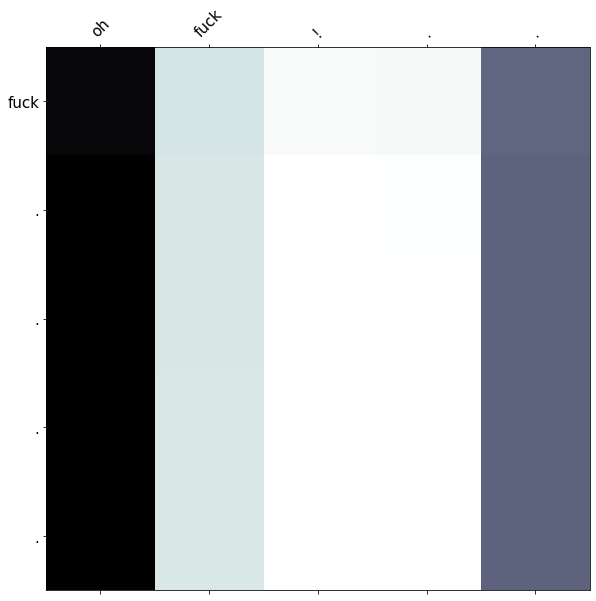

In [318]:
from matplotlib import pyplot as plt
from matplotlib import ticker
display_attention([words[int(ind)] for ind in src.numpy()], translation, attention)

In [31]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    epoch_loss = 0

    for idx, (index, vects) in enumerate(d.items()):
        # each is N x 300
        input_state, next_state = vects[0], vects[1]
        # raw strings corresponding to embeddings
        raw_input_state, raw_next_state = list(raw.keys())[index], raw[list(raw.keys())[index]]
        
        mu = actor(input_state.unsqueeze(0))
        
    for i, batch in enumerate(iterator):
        
        src, src_len = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        output = model(src, src_len, trg)
        output_dim = output.shape[-1]
        
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        
        loss = criterion(output, trg)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)


In [32]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src, src_len = batch.src
            trg = batch.trg

            output = model(src, src_len, trg, 0) #turn off teacher forcing
            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [33]:
N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    #start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    #end_time = time.time()
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut4-model.pt')
    
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

NameError: name 'train_iterator' is not defined

In [12]:
actor = EncRnn(hidden_size=2, num_layers=2, embed_size=300)
actor_criterion = torch.nn.MSELoss()
actor_optimizer = torch.optim.Adam(actor.parameters(), lr=0.001)
#print(actor)

running_loss=0.0
for idx, (index, vects) in enumerate(d.items()):
    # each is N x 300
    input_state, next_state = vects[0], vects[1]
    # raw strings corresponding to embeddings
    raw_input_state, raw_next_state = list(raw.keys())[index], raw[list(raw.keys())[index]]
    
    mu = actor(input_state.unsqueeze(0))
    
    # ACTOR FORMAT
    logstd = torch.zeros_like(mu.detach())
    std = 0.05*torch.exp(logstd)
    action = get_action(mu.detach(), std)[0]
    
    print(raw_input_state," || ",get_raw_action(action))
    # non greedy and greedy sim
    print(raw_next_state, 'non-greedy:', get_cosine_sim(next_state, action), 'greedy:', get_cosine_sim(next_state, action, type='greedy'))
    print("\n")
    # CONVENTIONAL TRAINING
    # zero the parameter gradients
    actor_optimizer.zero_grad()
    # forward + backward + optimize
    if idx == 0:
        print(mu.shape, next_state.shape)
    loss = actor_criterion(mu.squeeze(0), next_state)
    loss.backward()
    actor_optimizer.step()

    # print statistics
    running_loss += loss.item()
    running_loss = 0.0

    if idx > 100:
        break

torch.Size([1, 5])
torch.Size([5, 1, 4]) torch.Size([4, 1, 2])
torch.Size([5, 1, 4]) torch.Size([1, 2])


AttributeError: 'tuple' object has no attribute 'detach'

In [9]:
class EncRnn(nn.Module):

    def __init__(self, hidden_size, num_layers,
                 device='cpu', drop_prob=0, lstm=True, feature_norm=False,
                 input_size=1, output_size=VOCAB_SIZE,
                 bidirectional=False):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.device = device
        self.bidirectional = bidirectional

        self.embedding = from_pretrained()

        self.memory_cell = torch.nn.GRU(input_size=input_size,
                                hidden_size=hidden_size,
                                num_layers=num_layers,
                                batch_first=True,
                                # make dropout 0 if num_layers is 1
                                dropout=drop_prob * (num_layers != 1),
                                bidirectional=bidirectional)
        if bidirectional:
            self.linear = nn.Linear(hidden_size * 2, output_size)
        else:
            self.linear = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(drop_prob)

    def init_hidden(self, batch_size=1):
        if self.bidirectional:
            h = torch.autograd.Variable(torch.zeros(1, batch_size, self.hidden_size * 2))
        else:
            h = torch.autograd.Variable(torch.zeros(1, batch_size, self.hidden_size))

        if self.device == 'cuda':
            return h.cuda()
        else:
            return h

    def forward(self, x):
        x = self.dropout(self.embedding(x))
        print(x.shape)
        x = x.view(1, -1, EMBED_DIM)
        ## packing for computation and performance
        #packed_x = torch.nn.utils.rnn.pack_padded_sequence(x, batch_first=True, lengths = [x.shape[1]]*x.shape[0])
        out, hidden = self.memory_cell(x) #(packed_x)
        #out, _ = torch.nn.utils.rnn.pad_packed_sequence(out, batch_first=True) # unpack
        #out = out.transpose(1,0)
        print(out.shape)
        if self.bidirectional:
            out = self.linear(out.view(-1, self.hidden_size * 2)) # batch_size x vocab_size
        else:
            out = self.linear(out.view(-1, self.hidden_size))
        out = F.log_softmax(out, dim=1)
        return out, hidden

    def batchNLLLoss(self, x, target):
        """
        Returns the NLL Loss for predicting target sequence.
        Inputs: inp, target
            - x: batch_size x seq_len
            - target: batch_size x seq_len
            x should be target with <s> (start letter) prepended
        """

        loss_fn = nn.NLLLoss()
        batch_size, seq_len = x.size()
        x = x.permute(1, 0)           # seq_len x batch_size
        target = target.permute(1, 0)     # seq_len x batch_size
        h = self.init_hidden(batch_size)

        loss = 0
        for i in range(seq_len):
            out, h = self.forward(x[i], h)
            loss += loss_fn(out, target[i])

        return loss     # per batc

    def batchPGLoss(self, x, target, reward):
        """
        Returns a pseudo-loss that gives corresponding policy gradients (on calling .backward()).
        Inspired by the example in http://karpathy.github.io/2016/05/31/rl/
        Inputs: x, target
            - x: batch_size x seq_len
            - target: batch_size x seq_len
            - reward: batch_size (discriminator reward for each sentence, applied to each token of the corresponding
                      sentence)
            inp should be target with <s> (start letter) prepended
        """

        batch_size, seq_len = x.size()
        x = x.permute(1, 0)          # seq_len x batch_size
        target = target.permute(1, 0)    # seq_len x batch_size
        h = self.init_hidden(batch_size)

        loss = 0
        for i in range(seq_len):
            out, h = self.forward(x[i], h)
            # TODO: should h be detached from graph (.detach())?
            for j in range(batch_size):
                loss += -out[j][target.data[i][j]]*reward[j]     # log(P(y_t|Y_1:Y_{t-1})) * Q

        return loss/batch_size


actor = EncRnn(hidden_size=2, num_layers=2, input_size=300)#, output_size=50) #Seq2Seq(hidden_size=2, num_layers=2, input_size=50, output_size=50)
actor_optimizer = torch.optim.Adam(actor.parameters(), lr=0.001)
#print(actor)

running_loss=0.0
for idx, (index, vects) in enumerate(d.items()):
    # each is N x 300
    input_state, next_state = vects[0], vects[1]
    # raw strings corresponding to embeddings
    raw_input_state, raw_next_state = list(raw.keys())[index], raw[list(raw.keys())[index]]
    
    for i in range(len(input_state)-1):
        tok = input_state[i]
        target = input_state[i+1]
        enc_in = tok.unsqueeze(0)
        enc_out, hidden = actor(enc_in)
        print(enc_out.shape, hidden.shape)

        actor_optimizer.zero_grad()
        print(target.unsqueeze(0).shape)
        loss = actor.batchNLLLoss(enc_in, target.unsqueeze(0))
        loss.backward()
        actor_optimizer.step()

    """
    # ACTOR FORMAT
    logstd = torch.zeros_like(mu.detach())
    std = 0.05*torch.exp(logstd)
    action = get_action(mu.detach(), std)[0]
    
    print(raw_input_state," || ",get_raw_action(action))
    # non greedy and greedy sim
    print(raw_next_state, 'non-greedy:', get_cosine_sim(next_state, action), 'greedy:', get_cosine_sim(next_state, action, type='greedy'))
    print("\n")
    """
    # CONVENTIONAL TRAINING
    # zero the parameter gradients
    actor_optimizer.zero_grad()
    # forward + backward + optimize
    print(next_state.unsqueeze(0).shape)
    loss = actor.batchNLLLoss(mu, next_state.unsqueeze(0))
    loss.backward()
    actor_optimizer.step()

    # print statistics
    running_loss += loss.item()
    running_loss = 0.0

    print(running_loss)

    if idx > 100:
        break

NameError: name 'VOCAB_SIZE' is not defined

In [25]:
#dir(model)

In [69]:
import spacy

In [71]:
nlp = spacy.load('./spacy-blank-GoogleNews/')

In [ ]:
for token_vector in action:
    v = token_vector.numpy()
    nlp.similarity(v, )

In [72]:
from numba import jit

@jit(nopython=True)
def cosine_similarity_numba(u:np.ndarray, v:np.ndarray):
    assert(u.shape[0] == v.shape[0])
    uv = 0
    uu = 0
    vv = 0
    for i in range(u.shape[0]):
        uv += u[i]*v[i]
        uu += u[i]*u[i]
        vv += v[i]*v[i]
    cos_theta = 1
    if uu != 0 and vv != 0:
        cos_theta = uv/np.sqrt(uu*vv)
    return cos_theta

In [73]:
def most_similar(word, topn=5):
  word = nlp.vocab[str(word)]
  queries = [
      w for w in word.vocab 
      if w.is_lower == word.is_lower and w.prob >= -15 and np.count_nonzero(w.vector)
  ]

  by_similarity = sorted(queries, key=lambda w: word.similarity(w), reverse=True)
  return [(w.lower_,w.similarity(word)) for w in by_similarity[:topn+1] if w.lower_ != word.lower_]

most_similar("dog", topn=3)

[]